In [2]:
import numpy as np
import scipy.signal as ss
import scipy.integrate as si
import matplotlib.pyplot as plt
import matplotlib.patches as plt2
from functions import *

clrs = plt.rcParams["axes.prop_cycle"].by_key()["color"]

#### ADC specs

In [3]:
fb = 10e6  # ADC bandwidth
OSR = 16  # Oversampling ratio
fs = 2 * fb * OSR  # Sampling frequency
order = 3  # Order of the modulator
h_inf = 2.85  # out-of-band gain
n_sample = 2**12  # Number of samples

#### Discrete time NTF synthesis

[78125.0, 160000000.0, -150, 40]


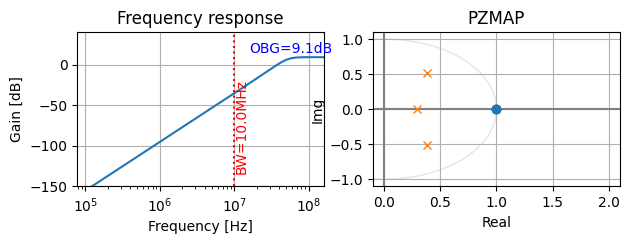

b = 1.000000, -3.000000, 3.000000, -1.000000
a = 1.000000, -1.055446, 0.631712, -0.119860
z = 1.000003+0.000006j, 1.000003-0.000006j, 0.999993+0.000000j
p = 0.380810+0.512749j, 0.380810-0.512749j, 0.293826+0.000000j
k = 1.000000


In [4]:
# create ntf
ntf = create_ntf(order, h_inf, fs, 0)

ntf[0] = ntf[0] * h_inf

z, p, k = ss.tf2zpk(ntf[0], ntf[1])
f, h = calc_freq(ntf, n_sample, fs, continuous=False)
fig, axs = plt.subplots(1, 2, figsize=(7, 2))
ax_lim = [f[1], f[int(n_sample / 2)], -150, 40]
print(ax_lim)
plot_freq(f, db20(h), axs[0], ax_lim)
axs[0].vlines(fb, ax_lim[2], ax_lim[3], color="red", linestyle=":")
axs[0].text(
    fb,
    ax_lim[2] + 0.1 * (ax_lim[3] - ax_lim[2]),
    "BW={:.1f}MHz".format(fb / 1e6),
    rotation=90,
    color="red",
)
axs[0].text(fs / 20, db20(h_inf) + 5, f"OBG={db20(h_inf):.1f}dB", color="blue")

plot_pzmap(z, p, axs[1], continuous=False)
plt.show()

# print transfer function
print("b = " + ", ".join(["{:.6f}".format(x) for x in ntf[0]]))
print("a = " + ", ".join(["{:.6f}".format(x) for x in ntf[1]]))
print("z = " + ", ".join(["{:.6f}".format(x) for x in z]))
print("p = " + ", ".join(["{:.6f}".format(x) for x in p]))
print("k = " + "{:.6f}".format(k))

In [5]:
# Open loop transfer function
L1 = [ntf[1] - ntf[0], ntf[0]]
# print(L1)
tf_print(L1, "L1", "z")

     +1.114e-09 z^3 +1.945e+00 z^2 -2.368e+00 z^1 +8.801e-01
L1 = -------------------------------------------------------
     +1.000e+00 z^3 -3.000e+00 z^2 +3.000e+00 z^1 -1.000e+00


In [6]:
# zero coefficient
# print(L1[1][-2])
g1 = 3 - L1[1][-2]
print("g1 = " + "{:.6f}".format(g1))

g1 = 0.000000


#### Impluse response

(array([[1.11387810e-09],
       [1.94455430e+00],
       [3.46537473e+00],
       [5.44260128e+00],
       [7.87623393e+00],
       [1.07662727e+01],
       [1.41127176e+01],
       [1.79155686e+01],
       [2.21748257e+01]]),)
[1.11387810e-09 1.94455430e+00 3.46537473e+00 5.44260128e+00
 7.87623393e+00 1.07662727e+01 1.41127176e+01 1.79155686e+01
 2.21748257e+01]


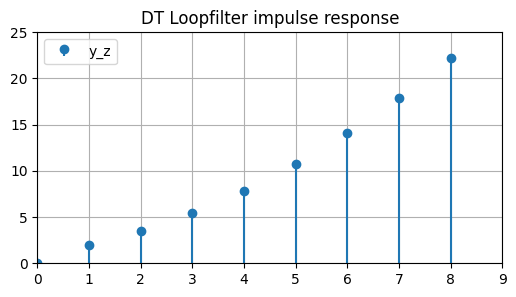

In [12]:
n_imp = order + 1  # number of samples

dtdsm3 = ss.dlti(L1[0], L1[1])

_, y_z = ss.dimpulse(dtdsm3, n=n_imp + 5)
print(y_z)
y_z = y_z[0][:, 0]
print(y_z)

# plot
plt.figure(figsize=(6, 3))
plt.stem(
    np.linspace(0, n_imp + 4, n_imp + 5),
    y_z[0 : n_imp + 5],
    basefmt=" ",
    linefmt=clrs[0],
)
plt.legend(["y_z"], loc="best")
plt.title("DT Loopfilter impulse response")
plt.axis([0, n_imp + 5, 0, 5 * np.ceil(y_z[-1] / 5)])
plt.grid()
plt.show()

In [13]:
# Integrator paths (set gains k1 and k2 to 1
# also ignore g1 feedback term through feedforward capacitor,
# otherwise you don't get unique solution):
int1_s = [arr([1, 0, 0]), arr([1 + 0.125 * g1, 0.5 * g1, g1, 0])]
int2_s = [arr([0, 1, 0]), arr([1 + 0.125 * g1, 0.5 * g1, g1, 0])]
int3_s = [arr([0, 0, 1]), arr([1 + 0.125 * g1, 0.5 * g1, g1, 0])]

# sampled integrator paths (dt versions of ct integrators):
method = "zoh"  # same as Schreier uses
int1_z = ss.cont2discrete(int1_s, dt=1, method=method)
int2_z = ss.cont2discrete(int2_s, dt=1, method=method)
int3_z = ss.cont2discrete(int3_s, dt=1, method=method)

# sampled integrator paths as LTI systems
I1_z = ss.dlti(np.trim_zeros(int1_z[0][0], trim="f"), int1_z[1])
I2_z = ss.dlti(np.trim_zeros(int2_z[0][0], trim="f"), int2_z[1])
I3_z = ss.dlti(np.trim_zeros(int3_z[0][0], trim="f"), int3_z[1])

In [14]:
# impulse responses of ct integrator paths:
_, x1_s = ss.dimpulse(I1_z, n=n_imp)
_, x2_s = ss.dimpulse(I2_z, n=n_imp)
_, x3_s = ss.dimpulse(I3_z, n=n_imp)
x1_s = x1_s[0][:, 0]
x2_s = x2_s[0][:, 0]
x3_s = x3_s[0][:, 0]
xmat_s = np.c_[x1_s, x2_s, x3_s]

# solve linear system with matrix multiplication
kall = np.matmul(
    np.linalg.inv(xmat_s[1 : order + 1, :]), np.transpose(y_z[1 : order + 1])
)
k1 = kall[0] / (1 + 0.125 * g1)
k2 = kall[1] - k1 * 0.5 * g1
k3 = kall[2] - k1 * g1

print("k1 = " + "{:.6f}".format(k1))
print("k2 = " + "{:.6f}".format(k2))
print("k3 = " + "{:.6f}".format(k3))
print("g1 = " + "{:.6f}".format(g1))

k1 = 1.336279
k2 = 1.064414
k3 = 0.456406
g1 = 0.000000


In [15]:
# Integrator paths (set gains k1, k2 and k3 to 1):
int1_s = [arr([k1 * (1 + 0.125 * g1), 0, 0]), arr([1 + 0.125 * g1, 0.5 * g1, g1, 0])]
int2_s = [arr([0, k2 + k1 * 0.5 * g1, 0]), arr([1 + 0.125 * g1, 0.5 * g1, g1, 0])]
int3_s = [arr([0, 0, k3 + k1 * g1]), arr([1 + 0.125 * g1, 0.5 * g1, g1, 0])]

# sampled integrator paths (dt versions of ct integrators):
method = "zoh"  # same as Schreier uses
int1_z = ss.cont2discrete(int1_s, dt=1, method=method)
int2_z = ss.cont2discrete(int2_s, dt=1, method=method)
int3_z = ss.cont2discrete(int3_s, dt=1, method=method)

# sampled integrator paths as LTI systems
I1_z = ss.dlti(np.trim_zeros(int1_z[0][0], trim="f"), int1_z[1])
I2_z = ss.dlti(np.trim_zeros(int2_z[0][0], trim="f"), int2_z[1])
I3_z = ss.dlti(np.trim_zeros(int3_z[0][0], trim="f"), int3_z[1])

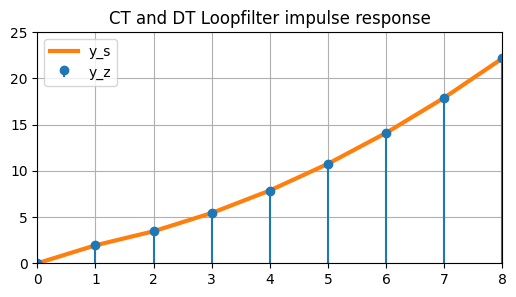

In [16]:
# impulse responses:
_, x1_s = ss.dimpulse(I1_z, n=n_imp + 5)
_, x2_s = ss.dimpulse(I2_z, n=n_imp + 5)
_, x3_s = ss.dimpulse(I3_z, n=n_imp + 5)
x1_s = x1_s[0][:, 0]
x2_s = x2_s[0][:, 0]
x3_s = x3_s[0][:, 0]
xall_s = np.c_[x1_s, x2_s, x3_s]

# plot
plt.figure(figsize=(6, 3))
plt.plot(
    np.linspace(0, n_imp + 4, n_imp + 5),
    np.sum(xall_s, axis=1)[0 : n_imp + 5],
    linewidth=3.0,
    color=clrs[1],
)
plt.stem(
    np.linspace(0, n_imp + 4, n_imp + 5),
    y_z[0 : n_imp + 5],
    basefmt=" ",
    linefmt=clrs[0],
)
plt.legend(["y_s", "y_z"], loc="best")
plt.title("CT and DT Loopfilter impulse response")
plt.axis([0, n_imp + 4, 0, 5 * np.ceil(y_z[-1] / 5)])
plt.grid()
plt.show()